### Choose from configuration files

In [1]:
# "2dLink", "2dFall", "2dSwim", "2dThrow", "2dTplate", "2dFallingCircle"
# "3dHinge", "3dPrismatic", "3dCylindrical"

casename = "2dFall";

### Include Dyn3d and config files

In [ ]:
using Pkg
Pkg.activate("..")

using Revise
using Dyn3d
using Interact, Reactive
using Plots
pyplot()

In [3]:
include("../src/config_files/"*casename*".jl");

Config info set up.


### Build joint-body chain

In [4]:
bodys, joints, system = BuildChain(config_bodys, config_joints,
                                   config_system)
bd = BodyDyn(bodys, joints, system)

This is a 8 body-joint system, system is fixed in space

### Initialize system state

In [5]:
# init system
bd, soln = InitSystem!(bd)

# init soln structure
solns = (Soln)[]
push!(solns, soln)

# init VertsHistory struct
vs = []
push!(vs, VertsHistory(system.nbody, bd.bs));

### Set up HERKBody object

In [6]:
herk = HERKBody(system.num_params,HERKFuncM, HERKFuncGT, HERKFuncG,
                (HERKFuncf,HERKFuncgti), (UpdatePosition!,UpdateVelocity!))

Order-3 HERK time-marching function like object for Dyn3d


### Time Marching

#### Note that sometimes the solver can break due to singular matrix. Change between fixed step or not to solve the problem

In [7]:
idx = 0
@time begin
while soln.t < tf
    # advance one step
    global soln, bd = herk(soln, bd)
#     soln, bd = herk(soln, bd, _isfixedstep=true)

    # record soln and verts_i info
    push!(solns, soln)
    push!(vs, VertsHistory(system.nbody, bd.bs))
        
    # print progress
    global idx += 1
    if mod(idx,500) == 1
        println("itr = $(idx), t = $(round(soln.t,digits=2)), dt = $(round(soln.dt,digits=4))")
    end
end
println("itr = $(idx), t = $(round(soln.t,digits=2)), dt = $(round(soln.dt,digits=4)) \n")
end

itr = 1, t = 0.0, dt = 0.0014
itr = 501, t = 1.17, dt = 0.0013
itr = 1001, t = 1.95, dt = 0.0019
itr = 1501, t = 3.0, dt = 0.0023
itr = 2001, t = 4.17, dt = 0.0009
itr = 2501, t = 4.72, dt = 0.0028
itr = 3001, t = 5.32, dt = 0.0008
itr = 3501, t = 6.16, dt = 0.0014
itr = 4001, t = 6.68, dt = 0.0009
itr = 4501, t = 7.3, dt = 0.0009
itr = 5001, t = 7.7, dt = 0.0013
itr = 5187, t = 8.0, dt = 0.0021 

 17.989159 seconds (26.78 M allocations: 5.718 GiB, 5.19% gc time)


### Generate verts data on regulated time grid

In [8]:
bodys, joints, system = bd.bs, bd.js, bd.sys

using Interpolations

# create regular time grid and acquire solutions on it
qJ_regs = Float64[]
t_reg = range(0,stop=solns[end].t,length=length(solns))
for i = 1:system.ndof
    t_temp = ([solns[k].t for k = 1:length(solns)],)
    qJ_temp = [solns[k].qJ[i] for k = 1:length(solns)]   
    qJ_reg = interpolate(t_temp, qJ_temp, Gridded(Linear()))(t_reg)
    append!(qJ_regs, qJ_reg)
end
qJ_regs = reshape(qJ_regs,(length(solns), system.ndof))

# get verts info based on this regular grid solution
vs_reg = []
bodys_reg = deepcopy(bodys)
joints_reg = deepcopy(joints)
system_reg = deepcopy(system)
for i = 1:length(solns)
    bodys_reg, joints_reg, system_reg = UpdatePosition!(bodys_reg, joints_reg, system_reg, solns[i].qJ)
    push!(vs_reg, VertsHistory(system.nbody, bodys_reg))
end

#### Store time-regulated verts in tuples

In [9]:
# plot direction
v = @isdefined(plot_dir) ? plot_dir : system.ndim==2 ? (1,2) : (1,2,3)

if system.ndim == 2
    # push the verts of all body in the same time into a tuple
    vs_total = []
    for i = 1:length(t_reg)
        vs_tmp = []
        for k = 1:system.nbody
            push!(vs_tmp,[vs_reg[i][k,:,v[1]],vs_reg[i][k,:,v[2]]])
        end
        push!(vs_total,vs_tmp)
    end
elseif system.ndim == 3
    h = [1:bodys[1].nverts;1]
    # push the verts of all body in the same time into a tuple
    vs_total = []
    for i = 1:length(t_reg)
        vs_tmp = []
        for k = 1:system.nbody
            push!(vs_tmp,[vs_reg[i][k,h,v[1]],vs_reg[i][k,h,v[2]],vs_reg[i][k,h,v[3]]])
        end
        push!(vs_total,vs_tmp)
    end       
end

### Interactive plot

In [10]:
# total number of frames for this interactive plot
plot_number = 50;

In [11]:
freq = round(Int,idx/plot_number)
camera_view = (45,45)

if system.ndim == 2
    @manipulate for i = 1:freq:length(t_reg)
        p = plot()        
        for j in 1:system.nbody
            plot!(vs_total[i][j][1],vs_total[i][j][2], linewidth=3)            
        end    
        plot!(xlims=(-2,2), ylims=(-2,2), aspect_ratio=:equal)        
    end
elseif system.ndim == 3
    @manipulate for i = 1:freq:length(t_reg)
        h = [1:bodys[1].nverts;1]
        p = plot()
        for j in 2:system.nbody
            plot!(vs_total[i][j][1],vs_total[i][j][2],vs_total[i][j][3], linewidth=3)
        end    
        plot!(xlims=(-2,2), ylims=(-2,2), zlims=(-2,2), aspect_ratio=:equal, camera = camera_view)     
    end
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Scope(Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :label), Any["i"], Dict{Symbol,Any}(:className=>"interact ",:style=>Dict{Any,Any}(:padding=>"5px 10px 0px 10px")))], Dict{Symbol,Any}(:className=>"interact-flex-row-left")), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :input), Any[], Dict{Symbol,Any}(:max=>50,:min=>1,:attributes=>Dict{Any,Any}(:type=>"range",Symbol("data-bind")=>"numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient"=>"horizontal"),:step=>1,:className=>"slider slider is-fullwidth",:style=>Dict{Any,Any}()))], Dict{Symbol,Any}(:className=>"interact-flex-row-center")), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes=>Dict("data-bind"=>"text: formatted_val")))], Dict{Symbol,Any}(:className=>"interact-flex-row-right"))], Dict{Symbol,Any}(:className=>"interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes"=>(Observable{Int64} with 1 listeners. Value:
0, nothing),"index"=>(Observable{Any} with 2 listeners. Value:
25, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "/home/fs/.julia/packages/Knockout/IP1uR/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/home/fs/.julia/packages/Knockout/IP1uR/src/../assets/knockout_punches.js"), Asset("js", nothing, "/home/fs/.julia/packages/InteractBase/sOe2Z/src/../assets/all.js"), Asset("css", nothing, "/home/fs/.julia/packages/InteractBase/sOe2Z/src/../assets/style.css"), Asset("css", nothing, "/home/fs/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes"=>Any[JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index"=>Any[JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Condition(Any[Task (runnable) @0x00007fd83877d870])), WebIO.JSString[JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"105\",\"209\",\"313\",\"417\",\"521\",\"625\",\"729\",\"833\",\"937\",\"1041\",\"1145\",\"1249\",\"1353\",\"1457\",\"1561\",\"1665\",\"1769\",\"1873\",\"1977\",\"2081\",\"2185\",\"2289\",\"2393\",\"2497\",\"2601\",\"2705\",\"2809\",\"2913\",\"3017\",\"3121\",\"3225\",\"3329\",\"3433\",\"3537\",\"3641\",\"3745\",\"3849\",\"3953\",\"4057\",\"4161\",\"4265\",\"4369\",\"4473\",\"4577\",\"4681\",\"4785\",\"4889\",\"4993\",\"5097\"],\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"17942271410795485346\",\"id\":\"11125924269523817091\",\

### Make gif

In [12]:
# Total number of seconds of this gif
gif_time = 8;

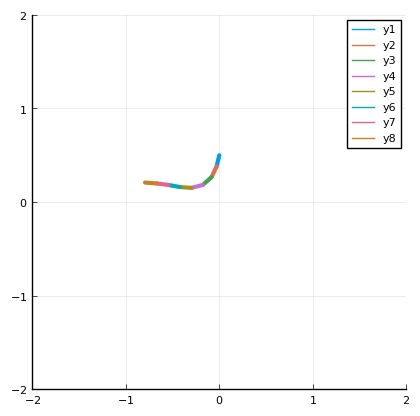

┌ Info: Saved animation to 
│   fn = /mnt/g/Research/Dyn3d.jl/notebook/2dFall.gif
└ @ Plots /home/fs/.julia/packages/Plots/E3MWZ/src/animation.jl:104


Plots.AnimatedGif("/mnt/g/Research/Dyn3d.jl/notebook/2dFall.gif")
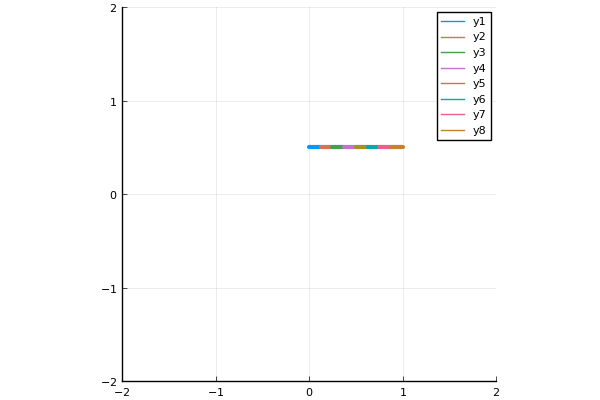

In [13]:
freq = round(Int,idx/30/gif_time)
camera_view = (45,45)

if system.ndim == 2
    anim = @animate for i = 1:freq:length(t_reg)
        p = plot()        
        for j in 1:system.nbody
            plot!(vs_total[i][j][1],vs_total[i][j][2], linewidth=3)            
        end    
        plot!(xlims=(-2,2), ylims=(-2,2), aspect_ratio=:equal)        
    end        
elseif system.ndim == 3 
    anim = @animate for i = 1:freq:length(t_reg)
        h = [1:bodys[1].nverts;1]
        p = plot()
        for j in 2:system.nbody
            plot!(vs_total[i][j][1],vs_total[i][j][2],vs_total[i][j][3], linewidth=3)
        end    
        plot!(xlims=(-2,2), ylims=(-2,2), zlims=(-2,2), aspect_ratio=:equal, camera = camera_view)
    end    
end
nothing
gif(anim, casename*".gif", fps = 30)